In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
import read_stuff as read
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_1230083/753694454.py:18: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
import importlib
importlib.reload(read)

<module 'read_stuff' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/read_stuff.py'>

In [4]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading input and outpus                    
└──────────────────────────────────────────────────────────────────────────"""
#Xtrain,Xvalid,Xtest,yall,yall_orig = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').read_Xy(num=33,needorig=False)
Xtrain,Xvalid,Xtest,yall = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').read_Xy(num=33,needorig='No')
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading PC structures for custom loss                       
└──────────────────────────────────────────────────────────────────────────"""
pcastore = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').pcastore
#wcomps = [26,18,48,14]
#upcs,vpcs,wpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['w'].components_[:wcomps[2]],pcastore['theta'].components_[:wcomps[3]]
wcomps = [50,38,8]
upcs,vpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['theta'].components_[:wcomps[2]]
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading y truth for custom loss                      
└──────────────────────────────────────────────────────────────────────────"""
#yTRUTH = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').y_truth(divider=divider,lti=24,num=33,withW=False)

  0%|          | 0/33 [00:00<?, ?it/s]

'──────────────────────────────────────────────────────────────────────────┐\n│ Loading y truth for custom loss                      \n└──────────────────────────────────────────────────────────────────────────'

In [16]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Which split will we be testing                     
└──────────────────────────────────────────────────────────────────────────"""
splitnum = 5

### PyTorch

#### Data processing

In [17]:
X_totrain,y_totrain = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[splitnum]['lwswdtthuvwqv'],yall_orig[splitnum][23][0])#yall_orig[splitnum][23][0])
X_tovalid,y_tovalid = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[splitnum]['lwswdtthuvwqv'],yall_orig[splitnum][23][1])#yall_orig[splitnum][23][1])
X_totest,y_totest = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[splitnum]['lwswdtthuvwqv'],yall_orig[splitnum][23][2])#yall_orig[splitnum][23][2])

In [18]:
calc_device = 'cpu'
###################################################################################
# Convert numpy arrays into tensors
###################################################################################
train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)

val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)

test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
test_ytensor = torch.FloatTensor(y_totest).to(calc_device)

train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)

###################################################################################
# Eigenvectors for Custom Loss in Physical Space
###################################################################################
eigenvectors = [torch.FloatTensor(obj).to(calc_device) for obj in [upcs,vpcs,wpcs,thpcs]]
###################################################################################
# Variances to calculate r2 in Physical Space
###################################################################################
varu,varv,varw,varth = np.var(yTRUTH['train'][splitnum]['du']),np.var(yTRUTH['train'][splitnum]['dv']),np.var(yTRUTH['train'][splitnum]['dw']),np.var(yTRUTH['train'][splitnum]['dth'])

#### Hyperparameters for training

In [9]:
batch_size = 9
num_workers = 2

#### DataLoader

In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False
)

#### Define Model Architecture

In [5]:
brchindex = [0,30,60,60+52,60+52+60]
brchsize = [30,30,52,60]

##### LW/SW

In [5]:
class OptimMLR_all_3D_simple(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [20,20]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        #self.dense3 = torch.nn.Linear(brchsize[2], 1)
        #self.dense4 = torch.nn.Linear(brchsize[3], 1)
        #self.dense5 = torch.nn.Linear(brchsize[4], 1)
        #self.dense6 = torch.nn.Linear(brchsize[5], 1)
        #self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(2,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestlw = self.dense1(X_lw)
        bestsw = self.dense2(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

##### LW/SW/HDIA

In [12]:
class OptimMLR_all_3D_simple_lwswhdia(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple_lwswhdia, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [82,20,20]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        #self.dense4 = torch.nn.Linear(brchsize[3], 1)
        #self.dense5 = torch.nn.Linear(brchsize[4], 1)
        #self.dense6 = torch.nn.Linear(brchsize[5], 1)
        #self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(3,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        besthdia = self.dense1(X_hdia)
        bestlw = self.dense2(X_lw)
        bestsw = self.dense3(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

##### All

In [5]:
class OptimMLR_all_3D_simple(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(7,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        besthdia = self.dense5(X_hdia)
        bestlw = self.dense6(X_lw)
        bestsw = self.dense7(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

#### All channels

In [6]:
class OptimMLR_all_2D(torch.nn.Module):
    def __init__(self):
        super(OptimMLR_all_2D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [26*2,18*2,48+12,14*2,9*2,6*3,30,30]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        self.dense8 = torch.nn.Linear(brchsize[7], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(8,106)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,26*2,18*2,48+12,14*2,9*2,6*3,30,30]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_rh, X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]],X[:,brchindex[7]:brchindex[8]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        bestrh = self.dense5(X_rh)
        besthdia = self.dense6(X_hdia)
        bestlw = self.dense7(X_lw)
        bestsw = self.dense8(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,bestrh,besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

In [11]:
from torchviz import make_dot
make_dot(mymodel(torch.rand((819,60))),params=dict(mymodel.named_parameters()))

NameError: name 'mymodel' is not defined

##### Custom Losses

In [7]:
class R2Loss(torch.nn.Module):
    
    def forward(self, y_pred, y):
        var_y = torch.var(y, unbiased=False)
        return -(1.0 - torch.nn.functional.mse_loss(y_pred, y, reduction="mean") / var_y)
    
class MSE_physicalLoss(torch.nn.Module):
    def __init__(self, pcs=None, wantcomps=None, variances=None):
        super(MSE_physicalLoss, self).__init__()
        self.pcs = pcs
        self.wantcomps = wantcomps
        self.variances = variances
        
    def forward(self, y_pred, y):
        def myscore(y_pred, y, var_y):
            return torch.mean(torch.square(y - y_pred).sum()).div(var_y)
            #var_y = torch.var(y, unbiased=False)
            #return (torch.nn.functional.mse_loss(y_pred, y, reduction="mean") / var_y) #mse/var
        """
        1. Here we slice the feature axis to separate samples into u/v/w/theta components
        """
        y_pred_u, y_u = y_pred[:,0:self.wantcomps[0]], y[:,0:self.wantcomps[0]]
        y_pred_v, y_v = y_pred[:,self.wantcomps[0]:self.wantcomps[0]+self.wantcomps[1]], y[:,self.wantcomps[0]:self.wantcomps[0]+self.wantcomps[1]]
        y_pred_w, y_w = y_pred[:,self.wantcomps[0]+self.wantcomps[1]:self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]], \
        y[:,self.wantcomps[0]+self.wantcomps[1]:self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]]
        y_pred_th, y_th = y_pred[:,self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]:self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]+self.wantcomps[3]], \
        y[:,self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]:self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]+self.wantcomps[3]]
        """
        2. Here we convert PCs into physical space
        """
        uphys_pred, uphys_real = torch.matmul(y_pred_u, self.pcs[0]),torch.matmul(y_u, self.pcs[0])
        vphys_pred, vphys_real = torch.matmul(y_pred_v, self.pcs[1]),torch.matmul(y_v, self.pcs[1])
        wphys_pred, wphys_real = torch.matmul(y_pred_w, self.pcs[2]),torch.matmul(y_w, self.pcs[2])
        thphys_pred, thphys_real = torch.matmul(y_pred_th, self.pcs[3]),torch.matmul(y_th, self.pcs[3])
        
        u_mse, v_mse, w_mse, th_mse = myscore(uphys_pred,uphys_real,self.variances[0]),myscore(vphys_pred,vphys_real,self.variances[1]),\
        myscore(wphys_pred,wphys_real,self.variances[2]),myscore(thphys_pred,thphys_real,self.variances[3])
        
        msesum = u_mse+v_mse+w_mse+th_mse
        return msesum/4#, u_mse,v_mse,w_mse,th_mse

#### Model compile settings

In [46]:
from torchsummary import summary
summary(model,input_size=(channels, H, W))

NameError: name 'channels' is not defined

#### Evaluation Loop

In [8]:
def eval_model(model, dataloader, loss_func, metric_func):
    with torch.no_grad():
        loss = 0
        metric = 0
        
        global_sum = 0
        label_size = 0
        for feature, labels in dataloader:
            global_sum += labels.sum()
            label_size += len(labels)
            
        global_mean = global_sum / label_size
        for features, labels in dataloader:
            pred = model(features)
            batch_loss = loss_func(pred, labels)
            batch_metric = metric_func(pred, labels, global_mean)
            
            loss+=batch_loss.item()
            metric+=batch_metric.item()
            
        num_batches = len(dataloader)
        
        loss = loss/num_batches
        metric = metric/num_batches
        return (loss, metric)
    
# Customzied evaluation metric NSE for validation set and test set # 
def calc_nse(sim: torch.FloatTensor, obs: torch.FloatTensor, global_obs_mean: torch.FloatTensor) -> float:
    """Calculate the Nash-Sutcliff-Efficiency coefficient.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :param global_obs_mean: mean of the whole observation series
    :return: NSE value.
    """
    numerator = torch.square(sim - obs).sum()
    #denominator = torch.square(obs - global_obs_mean).sum()
    #nse_val = 1 - numerator / denominator

    return numerator

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            #self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
from livelossplot import PlotLosses

In [10]:
def train_model(optimizer=None,scheduler=None,numepochs=None,early_stopper=None,variance_store=None,lossfunc=None,regularization='None',l1_lambda=0.01):
    # Custom loss: MSE_physicalLoss(eigenvectors,wcomps,variance_store)
    liveloss = PlotLosses()
    schedulerCY,schedulerLS = scheduler[1],scheduler[0]
    train_losses,trainu_losses,trainv_losses,trainw_losses,trainth_losses = [],[],[],[],[]
    val_losses = []
    val_NSEs = []
    for epoch in tqdm(range(int(num_epochs))):
        """
        Initialize loss
        """
        train_loss = 0
        """
        Operate per batch
        """
        for features, labels in train_loader:
            optimizer.zero_grad()
            
            prediction = model(features)
            batch_loss = lossfunc(prediction, labels)#loss_func(prediction, labels)
            
            if regularization=='L1':
                #L1 regularization-------------------------------
                l1_norm = sum(abs(p) for p in model.parameters())
                #-------------------------------------------------
                batch_loss = batch_loss + l1_lambda * l1_norm
                batch_loss.backward()
            elif regularization=='None':
                batch_loss.backward()                
            
            optimizer.step()
            schedulerCY.step()
            
            train_loss += batch_loss.item()
            
            
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        val_loss, val_NSE = eval_model(model,
                                       val_loader,
                                       lossfunc,
                                       calc_nse)
        schedulerLS.step(val_loss)
        
        ##################################################################
        # Early Stopping (valid / train)
        ##################################################################
        counter = 0
        if len(val_losses)>=1:
            best_score = val_losses[-1]
            if val_loss > best_score:
                counter += 1
                val_NSEs.append(val_NSE)
                val_losses.append(val_loss)
                if counter >= 10:
                    break
            else:
                val_NSEs.append(val_NSE)
                val_losses.append(val_loss)
        else:
            val_NSEs.append(val_NSE)
            val_losses.append(val_loss)
        
        if early_stopper.__call__(val_loss, model):
            break
        #if early_stopper.early_stop(val_loss):             
        #    break
            ##################################################################
        #val_NSEs.append(val_NSE)
        #val_losses.append(val_loss)
        
        if epoch % 500 == 0:
            print((np.log10(train_loss),np.log10(val_loss)))
            
    #return model, {'train':train_losses,'utrain':trainu_losses,'vtrain':trainv_losses,'wtrain':trainw_losses,'thtrain':trainth_losses,'val':val_losses} 
    return model, {'train':train_losses,'val':val_losses} 

In [ ]:
#splitnum = 5
from livelossplot import PlotLosses
for splitnum in range(33):
    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[splitnum]['lwswdtthuvw'],yall[splitnum][23][0])#yall_orig[splitnum][23][0])
    X_tovalid,y_tovalid = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[splitnum]['lwswdtthuvw'],yall[splitnum][23][1])#yall_orig[splitnum][23][1])
    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[splitnum]['lwswdtthuvw'],yall[splitnum][23][2])#yall_orig[splitnum][23][2])
    calc_device = 'cpu'
    ###################################################################################
    # Convert numpy arrays into tensors
    ###################################################################################
    train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
    train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
    val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
    val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
    test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
    test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
    train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
    val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
    test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
    ###################################################################################
    # Eigenvectors for Custom Loss in Physical Space
    ###################################################################################
    #eigenvectors = [torch.FloatTensor(obj).to(calc_device) for obj in [upcs,vpcs,thpcs]]#[upcs,vpcs,wpcs,thpcs]]
    ###################################################################################
    # Variances to calculate r2 in Physical Space
    ###################################################################################
    #varu,varv,varw,varth = np.var(yTRUTH['train'][splitnum]['du']),np.var(yTRUTH['train'][splitnum]['dv']),np.var(yTRUTH['train'][splitnum]['dw']),np.var(yTRUTH['train'][splitnum]['dth'])
    #varu,varv,varth = np.var(yTRUTH['train'][splitnum]['du']),np.var(yTRUTH['train'][splitnum]['dv']),np.var(yTRUTH['train'][splitnum]['dth'])
    batch_size = 9
    num_workers = 2
    train_loader = torch.utils.data.DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=val_data,
        batch_size=batch_size,
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False
    )
    
    times = ['exp1a','exp1b','exp1c','exp1d','exp1e']
    #times = ['exp2a','exp2b','exp2c']#,'exp1d','exp1e']
    for i in range(len(times)):
        models,losses = [],[]
        #model = OptimMLR_all_2D()
        model = OptimMLR_all_3D_simple_lwswhdia()
        optimizers = [torch.optim.Adam(model.parameters(), lr=1e-7)]#, optim.AdaBound(model.parameters(),lr=1e-7)] 1e-6
        loss = torch.nn.MSELoss()
        for optimizer in optimizers:
            scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=1e-5,cycle_momentum=False)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=1e-18)
            num_epochs = 1000*18#26
            early_stopper = EarlyStopping(patience=50, verbose=False, delta=1e-7, path='checkpoint.pt', trace_func=print)#EarlyStopper(patience=8, min_delta=1e-3)
            #variance_store = [varu,varv,varw,varth]
            #variance_store = [varu,varv,varth]
            model,loss = train_model(optimizer=optimizer,scheduler=[scheduler,scheduler2],numepochs=num_epochs,early_stopper=early_stopper,variance_store=None,\
                                     lossfunc=loss)
            models.append(model)
            losses.append(loss)
        torch.save(models, './tmp/torch_try/lwswhdia/0/models'+str(splitnum)+'_LWSW3d_1115_'+str(times[i])+'.pt')
        read_and_proc.save_to_pickle('./tmp/torch_try/lwswhdia/0/losses'+str(splitnum)+'_LWSW3d_1115_'+str(times[i])+'.pkt',losses,'PICKLE')

  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6635204039418163, -0.7052343966965914)
(-1.8003931993560303, -1.5121317176352351)
(-3.7720023261751554, -2.5444933778574694)
(-4.388018912966707, -3.391572368144545)
(-4.54206329868348, -3.7824712128882862)
(-4.574300350424398, -4.097865176703948)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6502718486033006, -0.6709505822528072)
(-1.745971506472698, -1.3189196342901495)
(-3.9148668111357114, -1.9753289398210616)
(-4.359306833988462, -2.345820421079841)
(-4.469166475687292, -2.6367456196709425)
(-4.5305842431944985, -2.967903179576849)
(-4.5640322190247975, -3.4683960193608168)
(-4.577809286414935, -4.408505038218072)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.616150010480405, -0.582319665185818)
(-1.5991699538815007, -1.465769617590589)
(-3.817069145804463, -2.4082695747625356)
(-4.42935201305585, -2.8206468860751253)
(-4.536341856408506, -3.335509655466694)
(-4.574622579022859, -4.160052173545035)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6825661634675836, -0.6711198414219931)
(-1.8200891960514916, -1.4306553906056374)
(-3.9648653996412833, -2.1983392843926586)
(-4.324798023635325, -2.53901863408828)
(-4.475600845550329, -2.8247122962647087)
(-4.5423615732200275, -3.120802896646416)
(-4.567418373075333, -3.527813760904141)
(-4.577134082397714, -4.217396946667081)
(-4.578961223081866, -4.577458034933588)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6866473783235884, -0.7845937963748282)
(-1.7779580534706985, -1.613733591856901)
(-3.8745252028813577, -2.4004740600051018)
(-4.4693361441682935, -2.8072627585759853)
(-4.549014961111718, -3.2186045843389333)
(-4.57258912092089, -3.7345370428339133)
(-4.578825945427644, -4.471422587939851)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6589741812698654, -0.6837752956534073)
(-1.7235572845257183, -1.4752915514539902)
(-3.616530575161735, -2.1866578955911398)
(-4.369337760035109, -2.656871852487402)
(-4.529569950264118, -3.0200288163321276)
(-4.5712320390582475, -3.5072384453627303)
(-4.582098669987925, -4.344043813084229)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6717248046686615, -0.5760319359247272)
(-1.8040213770110323, -1.4169352569275304)
(-3.744972339969493, -2.213321324061377)
(-4.384515692021265, -3.0156939078614897)
(-4.55740841797866, -3.7515816339921813)
(-4.586453740656808, -4.530140657907341)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6542363467087742, -0.6946932453891038)
(-1.7053267541950643, -1.4530246401752347)
(-4.097832915834459, -2.423452070820156)
(-4.51927708436548, -3.106850660644762)
(-4.574522296621125, -3.668395585173084)
(-4.5855765139567515, -4.529094574186772)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6355942165910419, -0.6749176887489636)
(-1.6380637144186632, -1.3990831696406878)
(-3.911563354993608, -2.370840255583204)
(-4.442243939682219, -3.143166806553651)
(-4.543550851637188, -3.5665601643181333)
(-4.575415940739497, -4.051559004639639)
(-4.585143626198146, -4.536962573555317)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6527701243912211, -0.6420077532957339)
(-1.8575026201828395, -1.3490480379902787)
(-3.8170789942002443, -2.0881139722717212)
(-4.44535367538094, -3.159883279047759)
(-4.581768466124654, -4.460782425370303)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7540273996057945, -0.8019269511997229)
(-1.9999271387732869, -1.6975839339406233)
(-3.8226931778487323, -2.468767812962733)
(-4.343494997218558, -2.924919345716971)
(-4.488899395010547, -3.2482737885614945)
(-4.575109025343504, -3.628199937540747)
(-4.616250946216741, -4.130784769780847)
(-4.617111806563156, -4.522681512502527)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6341228352407845, -0.6928689303664762)
(-1.6429083865291625, -1.4520629806390586)
(-3.8254881969990913, -2.328206579300177)
(-4.53004166565016, -3.196692192476629)
(-4.580065307176271, -4.395619498362962)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6467132595726554, -0.7473641131496658)
(-1.6424743522882195, -1.492243801068232)
(-3.350471249971562, -2.2170460180772267)
(-4.323343179861767, -2.635691232708792)
(-4.477788731002272, -2.9055472419152606)
(-4.536908114018698, -3.1985503505865154)
(-4.563245494806561, -3.566851651724191)
(-4.575127142799788, -4.087367182862172)
(-4.577593965886483, -4.4952874034472305)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.646183949053294, -0.5832656701351238)
(-1.6775358695950042, -1.2939030269984397)
(-4.019050028615642, -1.9883364039550289)
(-4.396678728763825, -2.472725785592788)
(-4.51340723777067, -2.9163819154300685)
(-4.563342109200509, -3.421122569873486)
(-4.582153968888708, -4.111591735270621)
(-4.586747282460301, -4.5019206390358075)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5977921586442665, -0.5947582572402146)
(-1.5640116640823185, -1.393202795533222)
(-3.3917723034910003, -2.4955645807032556)
(-4.4124695523786315, -2.90675137904009)
(-4.507240927059586, -3.123875630915793)
(-4.550905031464018, -3.426811298106774)
(-4.575696114376649, -3.8987137613912424)
(-4.582127107131661, -4.4764188159544345)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6233061223221166, -0.6346993181959639)
(-1.7406245359237726, -1.5533603522280337)
(-3.787979538468442, -2.9274681310182444)


#### LW+SW

#### LW+SW+U+W

/tmp/ipykernel_440483/4243838913.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


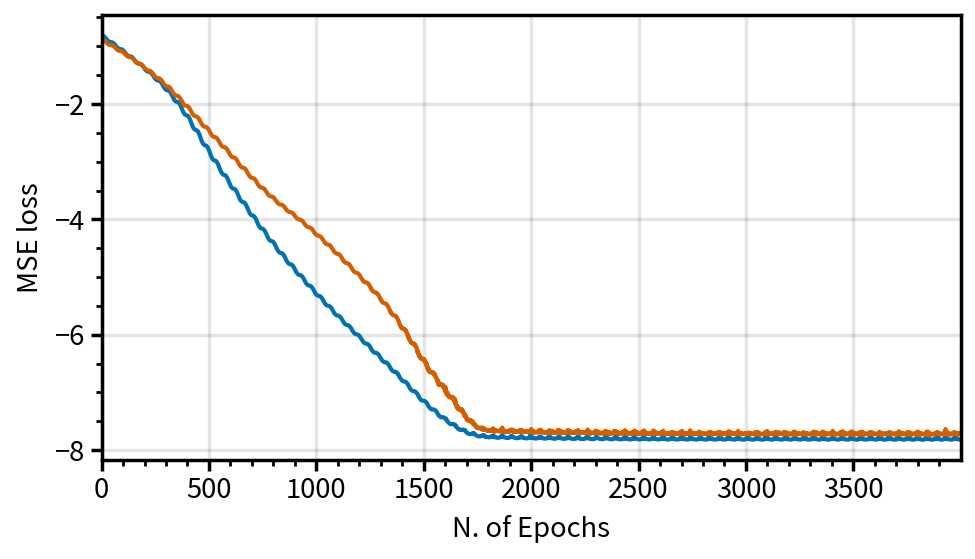

In [26]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig, ax1 = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.931,share=False)
ax1.plot(np.log10(losses[0]['train'][:]),label='training loss')
ax1.plot(np.log10(losses[0]['val'][:]),label='valid loss')
ax1.format(xlabel='N. of Epochs', ylabel='log10(MSE loss)')
plt.savefig('./analysis/pic/lossdiagram.png',dpi=400)
plt.show()

/tmp/ipykernel_1847357/3712731464.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


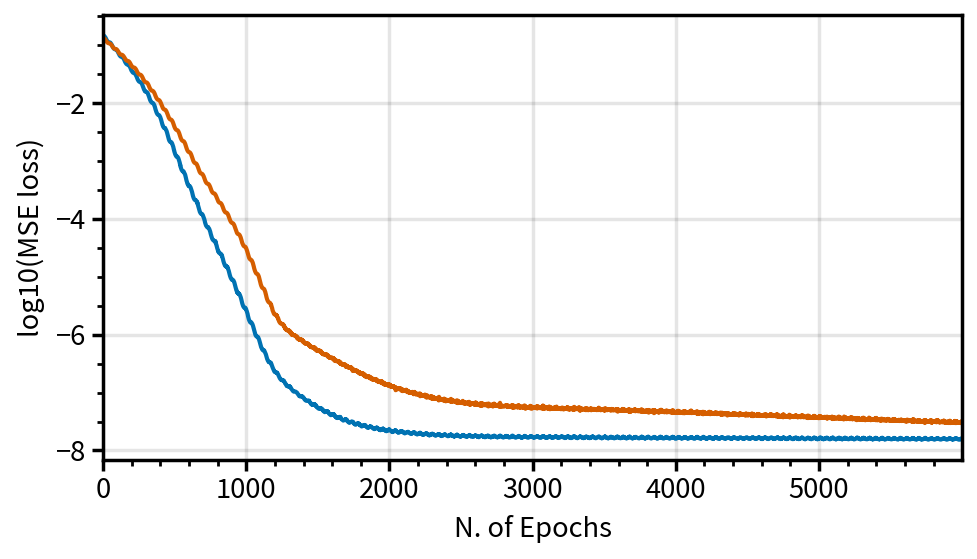

In [36]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig, ax1 = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.931,share=False)
ax1.plot(np.log10(losses[0]['train'][:]),label='training loss')
ax1.plot(np.log10(losses[0]['val'][:]),label='valid loss')
ax1.format(xlabel='N. of Epochs', ylabel='log10(MSE loss)')#,ylim=[-8,-7.5])
#plt.savefig('./analysis/pic/lossdiagram.png',dpi=400)
plt.show()

/tmp/ipykernel_440483/1894499735.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


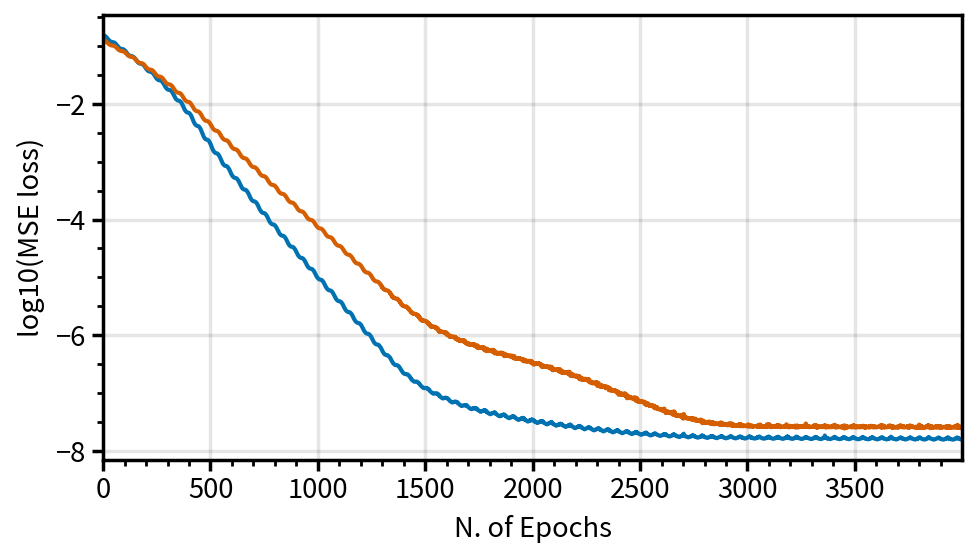

In [30]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig, ax1 = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.931,share=False)
ax1.plot(np.log10(losses[0]['train'][:]),label='training loss')
ax1.plot(np.log10(losses[0]['val'][:]),label='valid loss')
ax1.format(xlabel='N. of Epochs', ylabel='log10(MSE loss)')
plt.savefig('./analysis/pic/lossdiagram2.png',dpi=400)
plt.show()

In [78]:
! pip install torch_optimizer

     |████████████████████████████████| 61 kB 10 kB/s  eta 0:00:011


In [58]:
def myMSE(tensorX=None, tensorY=None, model=None, pcastore=None,var=[varu,varv,varw,varth]):
    def myscore(y_pred, y, var_y):
        #var_y = torch.var(y, unbiased=False)
        return (np.sum((y - y_pred)**2)) / var_y #mse/var
    
    utru = np.dot(tensorY.detach().numpy()[:,:26],pcastore['u'].components_[:26])
    upre = np.dot(model(tensorX).detach().numpy()[:,:26],pcastore['u'].components_[:26])
    vtru = np.dot(tensorY.detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
    vpre = np.dot(model(tensorX).detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
    wtru = np.dot(tensorY.detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    wpre = np.dot(model(tensorX).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    thtru = np.dot(tensorY.detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    thpre = np.dot(model(tensorX).detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    
    umse = myscore(upre,utru,var[0])
    vmse = myscore(vpre,vtru,var[1])
    wmse = myscore(wpre,wtru,var[2])
    thmse = myscore(thpre,thtru,var[3])
    return (umse+vmse+wmse+thmse)/4, umse,vmse,wmse,thmse

In [59]:
trainu_losses[-1],trainv_losses[-1],trainw_losses[-1],trainth_losses[-1],train_losses[-1]

(1195322.427734375,
 612982.1281738281,
 21422826.21875,
 880272.7783203125,
 66240.11946256868)

In [35]:
myMSE(tensorX=train_Xtensor, tensorY=train_ytensor, model=model, pcastore=pcastore)

(63199537080.81876,
 90842320181.89835,
 10618086608.285873,
 150571363619.71063,
 766377913.3802272)

In [37]:
surfix = '1625'
torch.save(models, './tmp/torch_try/1025/1/models_lwswuv_1102_'+str(surfix)+'.pt')
read_and_proc.save_to_pickle('./tmp/torch_try/1025/1/losses_lwswuv_1102_'+str(surfix)+
                '.pkt',losses,'PICKLE')

In [74]:
#plt.plot([obj.detach().numpy() for obj in trainv_losses])
plt.plot(train_losses)
plt.plot(val_losses)
#plt.plot(val_NSEs)
plt.ylim(-2,1)
plt.show()

NameError: name 'train_losses' is not defined

In [119]:
aaaaaa_th = np.dot(test_ytensor.detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
aaaaaa_w = np.dot(test_ytensor.detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
aaaaaa_v = np.dot(test_ytensor.detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
aaaaaa_u = np.dot(test_ytensor.detach().numpy()[:,:26],pcastore['u'].components_[:26])

In [120]:
bbbbbb_th = np.dot(model(test_Xtensor).detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
bbbbbb_w = np.dot(model(test_Xtensor).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
bbbbbb_v = np.dot(model(test_Xtensor).detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
bbbbbb_u = np.dot(model(test_Xtensor).detach().numpy()[:,:26],pcastore['u'].components_[:26])

In [108]:
def myr2(truth,pred):
    MSE = np.sum((truth-pred)**2)
    VAR = np.sum((truth-np.mean(truth))**2)
    return np.mean(1-MSE/VAR), MSE,VAR
myr2(aaaaaa,bbbbbb)

(0.37951426305479874, 8.465318223185857e-05, 0.00013643050466981933)

In [112]:
# v
myr2(aaaaaa,bbbbbb) 

(0.6406571144313491, 0.00023148038979969583, 0.0006441769103996147)

In [115]:
# w (var/error)
myr2(aaaaaa,bbbbbb)

(-21.816496008088382, 1.0253462547992716e-05, 4.4938813323298603e-07)

In [118]:
# theta
myr2(aaaaaa,bbbbbb)

(0.5462829087013954, 2.9929102560471313e-05, 6.596423880530894e-05)

#### No Early Stopping

In [146]:
# theta
myr2(aaaaaa,bbbbbb)

0.5539370425094943

In [143]:
# w
myr2(aaaaaa,bbbbbb)

-10.444096639815301

In [149]:
# v
myr2(aaaaaa,bbbbbb)

0.7852923241310666

In [152]:
# u
myr2(aaaaaa,bbbbbb)

0.36458807362049384